In [1]:
!pip install pickle5

     |████████████████████████████████| 256 kB 7.8 MB/s 


## Carga de librerías

In [2]:
from google.colab import drive
import glob
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle5 as pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPool2D,Flatten,Dropout,Dense
from tensorflow.keras.regularizers import l1_l2,l1,l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


In [3]:
drive.mount('/content/drive')
path="/content/drive/MyDrive/maestria_ciencia_datos/semestre2/aprendizaje_profundo/proyecto/"

Mounted at /content/drive


## Carga de imágenes

In [ ]:
# Única ejecución

#image_names_partially_covered = glob.glob(path+'data/partially_covered/*.jpg')
#image_names_not_face = glob.glob(path+'data/not_face/*.jpg')
#image_names_not_covered = glob.glob(path+'data/not_covered/*.jpg')
#image_names_fully_covered = glob.glob(path+'data/fully_covered/*.jpg')

In [ ]:
# Única ejecución

#X_partially_covered =  [imread(img_name) for img_name in image_names_partially_covered]
#X_not_face =  [imread(img_name) for img_name in image_names_not_face]
#X_not_covered =  [imread(img_name) for img_name in image_names_not_covered]
#X_fully_covered =  [imread(img_name) for img_name in image_names_fully_covered]

In [ ]:
# Única ejecución

#pd.to_pickle(X_partially_covered,path+"data/partially_covered.pkl")
#pd.to_pickle(X_not_face,path+"data/not_face.pkl")
#pd.to_pickle(X_not_covered,path+"data/not_covered.pkl")
#pd.to_pickle(X_fully_covered,path+"data/fully_covered.pkl")

In [4]:
infile=open(path+'data/partially_covered.pkl', 'rb')
X_partially_covered=pickle.load(infile)
infile.close()

infile=open(path+'data/not_face.pkl', 'rb')
X_not_face=pickle.load(infile)
infile.close()

infile=open(path+'data/not_covered.pkl', 'rb')
X_not_covered=pickle.load(infile)
infile.close()

infile=open(path+'data/fully_covered.pkl', 'rb')
X_fully_covered=pickle.load(infile)
infile.close()

In [5]:
X_partially_covered=np.array(X_partially_covered)
X_not_face=np.array(X_not_face)
X_not_covered=np.array(X_not_covered)
X_fully_covered=np.array(X_fully_covered)

print(f"Partially covered shape: {X_partially_covered.shape}")
print(f"Not face shape: {X_not_face.shape}")
print(f"Not covered shape: {X_not_covered.shape}")
print(f"Fully covered shape: {X_fully_covered.shape}")


Partially covered shape: (392, 64, 64)
Not face shape: (1114, 64, 64)
Not covered shape: (3664, 64, 64)
Fully covered shape: (1451, 64, 64)


## Feature engineering

In [6]:
X=np.concatenate((X_partially_covered,X_not_face,X_not_covered,X_fully_covered),axis=0)
Y=np.concatenate((np.repeat(1, X_partially_covered.shape[0]),np.repeat(2, X_not_face.shape[0]),
                  np.repeat(3, X_not_covered.shape[0]),np.repeat(4, X_fully_covered.shape[0])),axis=0).reshape(-1,1)
one = OneHotEncoder()
Y=one.fit_transform(Y).toarray()

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=0)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.15/(1-0.1),random_state=1)

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

## Modelo

In [ ]:
checkpoints = ModelCheckpoint(
                            path+"data/checkpoint_mejor_modelo_v1.h5",
                            monitor='val_loss', ## que funcion monitorea para crear el checkpoint
                            verbose=10, ## imprima que guardo un checkpoint
                            save_best_only=True, ## solo guarde el mejor model
                            save_weights_only=False, ## Nos guarda la arquitectura y los pesos
                            mode="min", ### Cuando guardar el checkpoint, en este caso, cada nuevo minimo en la funcion de val_loss
                            save_freq='epoch') ### Cada cuando guarda el checkpoint

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(64,64,1))) ## las dimensiones de la imagen
model.add(Conv2D(filters= 16 , kernel_size=(2,2),strides=(1,1), padding="same", activation = "relu" ))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid')) 
model.add(Dropout(0.2))
model.add(Conv2D(filters= 32 , kernel_size=(3,3),strides=(1,1), padding="same", activation = "LeakyReLU" ))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid'))  
model.add(Conv2D(filters= 64 , kernel_size=(2,2),strides=(1,1), padding="same", activation = "relu" ))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid')) 
model.add(Flatten()) ## convetimos un tensor de cualesquiera dimensiones a un vector 
model.add(Dropout(0.2))
model.add(Dense(units=256, activation ="relu"))
model.add(Dense(units=128, activation ="LeakyReLU"))
model.add(Dense(units=64, activation ="relu", kernel_regularizer= l1_l2(0.01,0.01)))
model.add(Dense(4, activation="softmax"))

model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(0.0001,), metrics= ["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        80        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
history = model.fit(X_train,Y_train, epochs= 100, batch_size =64, validation_data=(X_val,Y_val),callbacks=[checkpoints])

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 8.8547 - accuracy: 0.5478
Epoch 1: val_loss improved from inf to 8.42656, saving model to /content/drive/MyDrive/maestria_ciencia_datos/semestre2/aprendizaje_profundo/proyecto/data/checkpoint_mejor_modelo_v1.h5
78/78 [==============================] - 2s 17ms/step - loss: 8.8547 - accuracy: 0.5478 - val_loss: 8.4266 - val_accuracy: 0.5549
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 7.9653 - accuracy: 0.6123
Epoch 2: val_loss improved from 8.42656 to 7.56110, saving model to /content/drive/MyDrive/maestria_ciencia_datos/semestre2/aprendizaje_profundo/proyecto/data/checkpoint_mejor_modelo_v1.h5
78/78 [==============================] - 1s 9ms/step - loss: 7.9653 - accuracy: 0.6123 - val_loss: 7.5611 - val_accuracy: 0.7019
Epoch 3/100
73/78 [===========================>..] - ETA: 0s - loss: 7.1573 - accuracy: 0.7087
Epoch 3: val_loss improved from 7.56110 to 6.76784, saving model to /content/drive

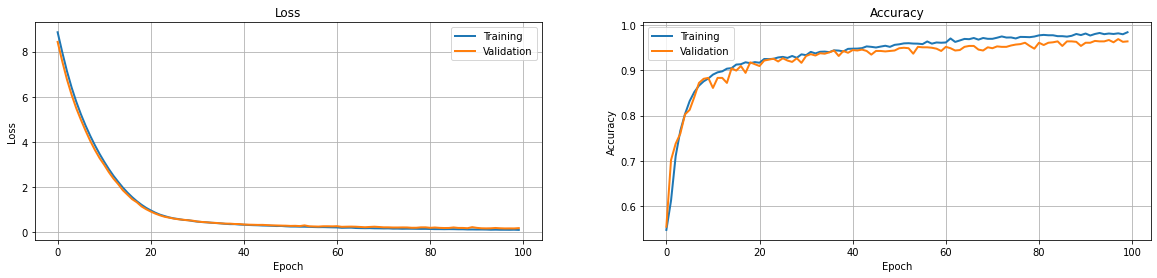

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(model.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(model.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

## Resultados

In [8]:
best_model = load_model(path+"data/checkpoint_mejor_modelo_v1.h5")

In [9]:
test_loss = best_model.evaluate(x=X_test, y=Y_test)

21/21 [==============================] - 9s 7ms/step - loss: 0.1623 - accuracy: 0.9729


In [10]:
Y_test_hat = best_model.predict(x=X_test)

Y_test_hat_cat = np.argmax(Y_test_hat, axis=1)
Y_test_cat = np.argmax(Y_test, axis=1)
cm=confusion_matrix(y_true=Y_test_cat, y_pred=Y_test_hat_cat)

print(cm)
print("\n")
print(np.round(np.transpose(np.transpose(cm)/cm.sum(axis=1)),3)*100)

[[ 37   0   0   0]
 [  0  87   2   3]
 [  0   2 369   0]
 [  1   2   8 152]]


[[100.    0.    0.    0. ]
 [  0.   94.6   2.2   3.3]
 [  0.    0.5  99.5   0. ]
 [  0.6   1.2   4.9  93.3]]


In [35]:
Y_test_hat = best_model.predict(x=X_test)
Y_test_cat = np.argmax(Y_test, axis=1)
Y_test_hat_cat = np.argmax(Y_test_hat, axis=1)

def cambio(x):
  if x==0:
    y="partially_covered"
  else:
    if x==1:
      y="not_face"
    else:
      if x==2:
        y="not_covered"
      else:
        if x==3:
          y="fully_covered"
        else:
          y=None
  return y

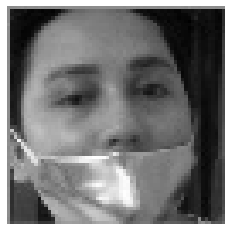

Real: partially_covered
Predict: partially_covered


In [74]:
i=639
plt.imshow(X_test[i],cmap='gray')
plt.axis('off')
plt.show()
print(f"Real: {cambio(Y_test_cat[i])}")
print(f"Predict: {cambio(Y_test_hat_cat[i])}")

In [73]:
np.where(Y_test_cat==0)

(array([ 64,  84,  89, 118, 137, 161, 178, 195, 196, 222, 227, 242, 247,
        257, 289, 296, 320, 352, 384, 418, 444, 447, 448, 450, 456, 463,
        473, 513, 527, 530, 557, 590, 600, 603, 604, 626, 639]),)